In [40]:
import re
import os
import json
import networkx as nx
from collections import Counter
import datetime
import matplotlib.pyplot as plt

In [108]:
def get_date(s):
    return datetime.datetime.strptime(s, '%Y-%m-%d %H:%M:%S')


names = [line for line in open('Ikon/extracted/all_artists_raw.dat')]

original2cleaned = {n : n.replace(',\n', '') for n in names}

names_cnt = {line.split('\t')[0]+'\n' : float(line.strip().split('\t')[1]) for line in open('Ikon/extracted/all_artists_cnt.dat') if len(line.strip().split('\t')) == 2}

names_first = {}
names_last  = {}

for line in open('Ikon/extracted/names_min_max_date.dat'):
    fields = line.strip().split('\t')
    if len(fields) == 3: 
        n, t1, t2 = fields
        names_first[n] = get_date(t1)
        names_last[n]  = get_date(t2)
        
        
print('Number of unique artist names: ', len(names))

Number of unique artist names:  27554


### First stage: replace and drop things that are obvisouly not ok

In [109]:
# replace these by ''
to_replace = [
    '..',
    ';.',
    '"',
    ')',
    '(',
    ',', 'művészettörténész', 'plakátművész', 'kortárs művész', 'résztvevő', 'résztvevők', 
    'képzőművész', ' művész', ' alkotó', 'filmesztéta'
    ]


# drop names that contain these
to_drop = [
    '2000',
    '100'
    ]

In [110]:
cleaned2original = {}


for original, cleaned in original2cleaned.items(): 

    todrop = False
    for td in to_replace:
        cleaned = cleaned.replace(td, '')
    for tk in to_drop:
        if tk in original:
            todrop = True

    if not tokill and len(cleaned) > 1:
        original2cleaned[original] = cleaned.strip()
        cleaned2original[cleaned.strip()] = original
        
for ind, (c, o) in enumerate(cleaned2original.items()):
    if ind == 1: break
    print(o, c)
    
    
print('\nNumber of unique artist names: ', len(names))
print('Number of artist names after first filter: ', len(cleaned2original.keys()))

Pásztor Péter
 Pásztor Péter

Number of unique artist names:  27554
Number of artist names after first filter:  24578


### Second stage: group the simialr names together

Let's do pairwise comparison between the name strings to catch different forms of the same name

Number of pairs above similarity score 64:  25676


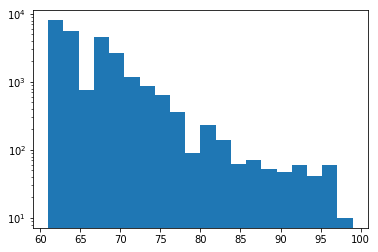

In [111]:
# pairwise comparison of all the names and computing their similarity
# by https://pypi.org/project/Fuzzy/

pairs_similarities = []

files = os.listdir('Ikon/name_matching')
sims  = []

for fn in files:  
    with open('Ikon/name_matching/' + fn) as f:
        next(f)
        for line in f:
            n1, n2, score = line.strip().split('\t')
            pairs_similarities.append((n1, n2, float(score)))  
            sims.append(float(score))
 
print('Number of pairs above similarity score 64: ', len(sims))

plt.hist(sims, bins = 20)
plt.yscale('log')

#### weighting based on frequency

In [112]:
similarity_limit = 0.9

for ind, (n1, n2, score) in enumerate(pairs_similarities[0:100]):
    if score > 80:
        a = 2
        print(n1, n2, score)       

Finnország magyarországi nagykövete Oroszország Magyarországi Nagykövete 82.0
Finnország magyarországi nagykövete FRanciaország magyarországi nagykövete 90.0
feLugossy László Fe Lugossy László 91.0
tanszékvezető egyetemi tanár tanszékvezető egyetemi docens 84.0
Vízy László Vitézy László 83.0
Vízy László Csízy László 87.0


#### filtering based on temporal overlaps

Seems that 80 does not give a perfect threshold, there are mismatches but still similar enough. Let's add the time of the first and last exhibition of these individuals as features as well and see if they overlap are close enough. I also add the number of times the different variants have occurred, and the less frequent as a modified version of the more frequent if the latter occurred at least X times more often.

In [114]:
#def intervals_overlap(s1, s2, e1, e2, delay):

def getOverlap(a, b):
    return abs((min(a[1], b[1]) - max(a[0], b[0])).days)


delay_limit = 2*365

for n1, n2, s in pairs_similarities[50:250]:
    
    if s > 80:

        start1 = names_first[cleaned2original[n1].strip()]
        start2 = names_first[cleaned2original[n2].strip()]
                
        end1 = names_last[cleaned2original[n1].strip()]
        end2 = names_last[cleaned2original[n2].strip()]        
        
        cnt1 = names_cnt[cleaned2original[n1]]
        cnt2 = names_cnt[cleaned2original[n2]]        
        
        delay = getOverlap([start1, end1], [start2, end2])
        
        print(delay)
        if delay > delay_limit:
            print('More than ', delay_limit, ' days of delay (', delay_limit ,')')

        print(start1, end1)
        print(start2, end2)
        
        print(n1, cnt1, '\t', n2, cnt2, '\n')
        
        

412
2005-10-20 18:00:00 2006-12-07 17:00:00
2005-06-27 10:00:00 2017-02-11 10:30:00
tanszékvezető egyetemi tanár 5.0 	 tanszékvezető egyetemi docens 4.0 

3596
More than  730  days of delay ( 730 )
2019-11-26 18:00:00 2019-11-27 18:30:00
2010-01-22 17:00:00 2010-01-22 17:00:00
Vízy László 2.0 	 Vitézy László 1.0 

1
2019-11-26 18:00:00 2019-11-27 18:30:00
2014-03-13 18:00:00 2019-12-14 16:00:00
Vízy László 2.0 	 Csízy László 17.0 

453
2000-11-25 17:00:00 2017-10-21 16:00:00
2003-04-05 12:00:00 2004-07-01 19:00:00
KissPál Szabolcs 66.0 	 KisPál Szabolcs 3.0 

603
2009-12-16 19:00:00 2018-10-14 15:00:00
2012-05-29 17:00:00 2014-01-22 18:00:00
Polyák Levente 12.0 	 Polyák Levente KÉK 4.0 

2651
More than  730  days of delay ( 730 )
2016-02-10 19:00:00 2016-02-11 19:00:00
2008-11-07 20:00:00 2008-11-07 20:00:00
Fisches Judit 2.0 	 Fischer Judit HU 1.0 

603
2012-05-29 17:00:00 2014-01-22 18:00:00
2009-12-16 19:00:00 2018-10-14 15:00:00
Polyák Levente KÉK 4.0 	 Polyák Levente 12.0 

453
20

It seems that e.g. in the case of Vízy and Csízy, the year-filtering is needed. However, Vízy, Vitézy, and Csízy seem to belong to the same similarity cluster, so pairwise comparisond and replacements may not be efficeient. Lets build a similarity graph!

#### building similarity graph components

In [130]:
G = nx.Graph()

delay_limit      = 2*365
similarity_limit = 80
frequency_limit  = 4
total_weight     = 5

for n1, n2, s in pairs_similarities:
    if s > similarity_limit:
        

        start1 = names_first[cleaned2original[n1].strip()]
        start2 = names_first[cleaned2original[n2].strip()]
        
        end1 = names_last[cleaned2original[n1].strip()]
        end2 = names_last[cleaned2original[n2].strip()]        
        
        cnt1 = names_cnt[cleaned2original[n1]]
        cnt2 = names_cnt[cleaned2original[n2]]    
        
 
        delay = getOverlap([start1, end1], [start2, end2])
    
        if delay < delay_limit:
            
        
            G.add_edge(n1, n2, weight = s)

print('Number of edges: ', len(G.edges))

components = sorted(nx.connected_components(G), key=len, reverse=True)

print('Number of similarity clusters: ', len(components))
for c in components:
    
    component_weight = sum([names_cnt[cleaned2original[cc]] for cc in c])
    
    if component_weight >= total_weight: 
        print(component_weight, list([(cc, names_cnt[cleaned2original[cc]]) for cc in c]))

Number of edges:  171
Number of similarity clusters:  160
15.0 [('a Magyar Képzőművészeti Egyetem tanára', 2.0), ('a Magyar Képzőművészeti Egyetem rektora', 7.0), ('a Magyar Képzőművészeti Egyetem rektorhelyettese', 4.0), ('Magyar Képzőművészeti Egyetem  Budapest', 2.0)]
73.0 [('KisPál Szabolcs', 3.0), ('KissPál Szabolcs', 66.0), ('KsPál Szabolcs', 4.0)]
48.0 [('Beke László', 44.0), ('Beke Lászó', 2.0), ('Lenkes László', 2.0)]
10.0 [('Mag Krisztina', 4.0), ('Vígh Krisztina', 4.0), ('Varga Krisztina', 2.0)]
15.0 [('egyetemi tanársegéd', 2.0), ('egyetemi tanár', 11.0), ('ny. egyetemi tanár', 2.0)]
55.0 [('Kauker Dóra', 6.0), ('maurer dóra', 2.0), ('Maurer Dóra', 47.0)]
39.0 [('Kőnig Frigyes', 37.0), ('Kőnig Figyes', 1.0), ('Dr Kőnig Frigyes', 1.0)]
8.0 [('Prof. König Frigyes', 2.0), ('Dr. Kőnig Frigyes', 4.0), ('prof. Kőnig Frigyes DLA', 2.0)]
32.0 [('Swierkewicz Róbert', 2.0), ('Swierkiewicz Róbert', 27.0), ('Swierkievicz Róbert', 3.0)]
17.0 [('Molnár Eszter', 2.0), ('Molnár Dóra Eszter

### Frequency distribution

1 	 22944
2 	 6948
3 	 5868
4 	 3740
5 	 3244
6 	 2560
7 	 2269
8 	 1920
9 	 1736


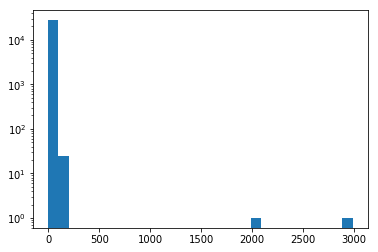

In [135]:
plt.hist(names_cnt.values(), bins = 30)
plt.yscale('log')
for i in range(1,10):
    print(i, '\t', len([_ for _ in names_cnt.values() if _ > i]))

In [ ]:
--- több név egy sorban

AATOTH • BODÓCZKY • BÖRÖCZ • BUKTA • CZIGÁNY • FEHÉR • FELUGOSSY • GILOT • GYŐRFFY • HERBST • HERMAN • HOLLÓS • JOVANOVICS • KAZOVSZKIJ • KESERÜ • KORNISS • MISETICS • MULASICS • NÁDLER • RÁCMOLNÁR • ROZSDA • SZIRTES • SZOTYORY • UJHÁZI • VÁRADY,
ANDREJKOVICS ZOLTÁN | BEÖTHY BALÁZS | LISA BUTTINGER | EIKE BERG | ELŐD ÁGNES | ERHARDT MIKLÓS | FELVIDÉKI MIKLÓS | GUTEMA DÁVID | IMPLAUSIBLE WORKS (SZEKERES AGNUS,